<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/1%EC%A3%BC%EC%B0%A8_speech_command_classification_with_torchaudio_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [22]:
print(torch.__version__)
!python -V

2.0.1+cu118
Python 3.8.6


In [4]:
#파이썬 버전 변경 3.10.12 -> 3.8.6
#ERROR: Could not find a version that satisfies the requirement torch==1.7.0+cpu (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
#ERROR: No matching distribution found for torch==1.7.0+cpu 해결
!wget https://www.python.org/ftp/python/3.8.6/Python-3.8.6.tgz
!tar xvfz Python-3.8.6.tgz
!Python-3.8.6/configure
!make
!sudo make install

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Compiling '/usr/local/lib/python3.8/importlib/abc.py'...
Compiling '/usr/local/lib/python3.8/importlib/machinery.py'...
Compiling '/usr/local/lib/python3.8/importlib/metadata.py'...
Compiling '/usr/local/lib/python3.8/importlib/resources.py'...
Listing '/usr/local/lib/python3.8/xmlrpc'...
Compiling '/usr/local/lib/python3.8/importlib/util.py'...
Compiling '/usr/local/lib/python3.8/inspect.py'...
Compiling '/usr/local/lib/python3.8/io.py'...
Compiling '/usr/local/lib/python3.8/ipaddress.py'...
Compiling '/usr/local/lib/python3.8/json/__init__.py'...
Compiling '/usr/local/lib/python3.8/json/decoder.py'...
Compiling '/usr/local/lib/python3.8/json/encoder.py'...
Compiling '/usr/local/lib/python3.8/json/scanner.py'...
Compiling '/usr/local/lib/python3.8/json/tool.py'...
Compiling '/usr/local/lib/python3.8/keyword.py'...
Compiling '/usr/local/lib/python3.8/lib2to3/__init__.py'...
Compiling '/usr/local/lib/python3.8/lib2to3/__main__.py'...
Compiling '/usr/l

In [5]:
#ERROR: command errored out with exit status 1 python setup.py egg_info 해결
!pip install --upgrade setuptools

     |████████████████████████████████| 807 kB 2.6 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.2.1
    Uninstalling setuptools-49.2.1:
      Successfully uninstalled setuptools-49.2.1


In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
# SpeechCommands 데이터세트 가져오기
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


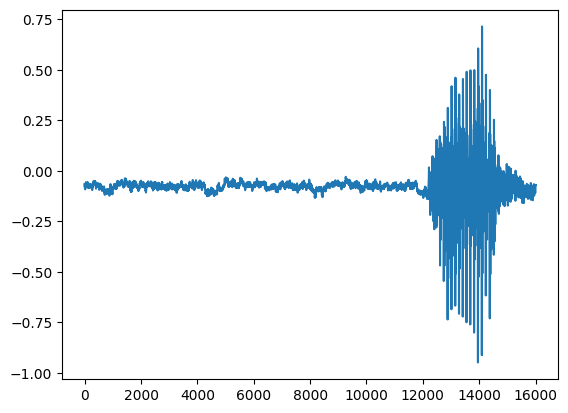

In [5]:
#웨이브폼 (waveform):시간에 따른 오디오 신호의 변화를 표현하는 시각적인 그래픽
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
#사용 가능한 라벨 목록
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “backward”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “zero”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data(전처리)

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [33]:
#transform 객체를 사용하여 데이터를 새로운 샘플 속도로 다시 샘플링함
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

We are encoding each word using its index in the list of labels.




In [9]:
#레이블 목록의 인덱스를 사용하여 각 단어를 인코딩
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [10]:
#리샘플링과 텍스트 인코딩
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [15]:
#M5 네트워크 아키텍처 모델
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [16]:
# Adam 최적화
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [17]:
#훈련 기능: 훈련 데이터를 모델에 공급하고 역방향 전달 및 최적화 단계를 수행하는 훈련 함수
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())



Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [18]:
#테스트 기능: 네트워크 정확도를 테스트하기 위한 기능
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.005333333333333333/2 [00:00<00:52, 26.08s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.376127


  3%|▎         | 0.06399999999999999/2 [00:01<00:50, 25.87s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.471527


  6%|▌         | 0.11199999999999995/2 [00:02<00:50, 26.49s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.598959


  8%|▊         | 0.16533333333333344/2 [00:04<00:48, 26.41s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.535726


 11%|█         | 0.218666666666667/2 [00:05<00:49, 27.62s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.511869


 14%|█▎        | 0.27200000000000035/2 [00:07<00:46, 26.91s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.477835


 16%|█▋        | 0.32533333333333336/2 [00:08<00:43, 25.75s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.481216


 19%|█▉        | 0.3786666666666664/2 [00:09<00:41, 25.81s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.649258


 22%|██▏       | 0.4373333333333327/2 [00:11<00:40, 25.64s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.433526


 24%|██▍       | 0.4853333333333324/2 [00:12<00:38, 25.64s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.588543


 27%|██▋       | 0.5386666666666662/2 [00:14<00:37, 25.65s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.654420


 30%|██▉       | 0.5973333333333337/2 [00:15<00:35, 25.55s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.507345


 33%|███▎      | 0.6506666666666678/2 [00:16<00:35, 26.12s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.428288


 35%|███▍      | 0.6986666666666685/2 [00:18<00:33, 25.77s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.511144


 38%|███▊      | 0.7520000000000027/2 [00:19<00:34, 27.80s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.501714


 40%|████      | 0.8053333333333368/2 [00:21<00:31, 26.20s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.522246


 43%|████▎     | 0.8586666666666709/2 [00:22<00:30, 27.13s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.619052


 50%|█████     | 1.0026666666666728/2 [00:26<00:24, 25.05s/it]


Test Epoch: 1	Accuracy: 8877/11005 (81%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.538891


 53%|█████▎    | 1.061333333333338/2 [00:27<00:24, 26.16s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.427526


 56%|█████▌    | 1.1146666666666698/2 [00:28<00:23, 26.04s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.430820


 58%|█████▊    | 1.1680000000000017/2 [00:30<00:21, 25.71s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.435227


 61%|██████    | 1.2213333333333336/2 [00:31<00:19, 25.47s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.505842


 64%|██████▎   | 1.2746666666666655/2 [00:33<00:18, 25.64s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.549162


 66%|██████▋   | 1.3279999999999974/2 [00:34<00:17, 26.31s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.461180


 69%|██████▉   | 1.3813333333333293/2 [00:36<00:18, 29.70s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.519324


 72%|███████▏  | 1.4346666666666612/2 [00:37<00:14, 26.29s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.465115


 74%|███████▍  | 1.487999999999993/2 [00:38<00:13, 26.75s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.568367


 77%|███████▋  | 1.541333333333325/2 [00:40<00:14, 31.70s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.495091


 80%|███████▉  | 1.594666666666657/2 [00:41<00:10, 25.81s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.495900


 82%|████████▏ | 1.6479999999999888/2 [00:43<00:09, 25.93s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.543832


 85%|████████▌ | 1.7013333333333207/2 [00:44<00:07, 26.67s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.466952


 88%|████████▊ | 1.7546666666666526/2 [00:45<00:06, 25.16s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.530675


 90%|█████████ | 1.8079999999999845/2 [00:47<00:05, 26.24s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.509957


 93%|█████████▎| 1.8613333333333164/2 [00:48<00:03, 26.43s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.696699


100%|█████████▉| 1.9999999999999793/2 [00:52<00:00, 26.13s/it]



Test Epoch: 2	Accuracy: 8802/11005 (80%)



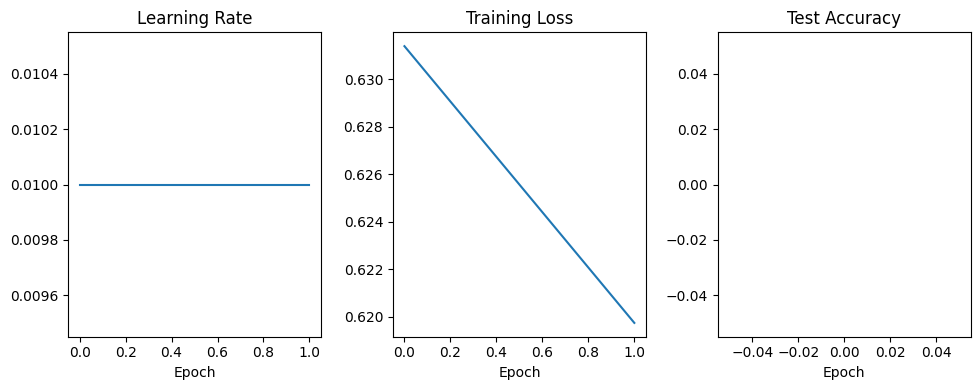

In [23]:
import matplotlib.pyplot as plt
#2에포크일 경우일 경우
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# Lists to store data for plotting
learning_rates = []
training_losses = []
test_accuracies = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test_acc = test(model, epoch)  # Store the returned accuracy in test_acc
        scheduler.step()

        # Record learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Record training loss
        training_losses.append(losses[-1])

        # Record test accuracy
        test_accuracies.append(test_acc)  # Use test_acc

# Plot learning rate
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# Plot training loss
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()

  0%|          | 0.005333333333333333/21 [00:00<10:12, 29.15s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.433660


  0%|          | 0.05866666666666665/21 [00:01<09:18, 26.69s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.446144


  1%|          | 0.11733333333333328/21 [00:03<09:16, 26.64s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.635170


  1%|          | 0.16533333333333344/21 [00:04<09:02, 26.03s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.489963


  1%|          | 0.218666666666667/21 [00:05<09:02, 26.12s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.501023


  1%|▏         | 0.27200000000000035/21 [00:07<08:52, 25.67s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.476164


  2%|▏         | 0.32533333333333336/21 [00:08<09:04, 26.33s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.586615


  2%|▏         | 0.3786666666666664/21 [00:09<08:47, 25.59s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.480592


  2%|▏         | 0.4319999999999994/21 [00:11<08:42, 25.38s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.528905


  2%|▏         | 0.4906666666666657/21 [00:12<08:38, 25.26s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.502744


  3%|▎         | 0.5386666666666662/21 [00:14<08:57, 26.25s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.463023


  3%|▎         | 0.5920000000000003/21 [00:15<09:04, 26.68s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.463144


  3%|▎         | 0.6453333333333344/21 [00:16<09:07, 26.89s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.564320


  3%|▎         | 0.6986666666666685/21 [00:18<08:55, 26.39s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.657629


  4%|▎         | 0.7520000000000027/21 [00:19<08:44, 25.92s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.601310


  4%|▍         | 0.8106666666666702/21 [00:21<08:44, 25.98s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.525599


  4%|▍         | 0.8586666666666709/21 [00:22<08:38, 25.77s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.623921


  5%|▍         | 1.0026666666666728/21 [00:25<08:07, 24.39s/it]


Test Epoch: 1	Accuracy: 8930/11005 (81%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.505769


  5%|▌         | 1.061333333333338/21 [00:27<08:27, 25.45s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.527238


  5%|▌         | 1.1146666666666698/21 [00:28<08:33, 25.83s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.449477


  6%|▌         | 1.1680000000000017/21 [00:30<08:46, 26.55s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.434920


  6%|▌         | 1.2213333333333336/21 [00:31<08:45, 26.57s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.560673


  6%|▌         | 1.2746666666666655/21 [00:33<08:50, 26.91s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.360373


  6%|▋         | 1.3279999999999974/21 [00:34<08:43, 26.61s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.584531


  7%|▋         | 1.3813333333333293/21 [00:35<08:36, 26.33s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.583669


  7%|▋         | 1.4346666666666612/21 [00:37<08:26, 25.90s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.535647


  7%|▋         | 1.487999999999993/21 [00:38<08:22, 25.77s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.594826


  7%|▋         | 1.541333333333325/21 [00:40<08:21, 25.78s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.574466


  8%|▊         | 1.594666666666657/21 [00:41<08:22, 25.90s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.509692


  8%|▊         | 1.6479999999999888/21 [00:42<08:17, 25.70s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.442984


  8%|▊         | 1.7013333333333207/21 [00:44<08:20, 25.93s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.645046


  8%|▊         | 1.7546666666666526/21 [00:45<08:27, 26.38s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.514484


  9%|▊         | 1.8079999999999845/21 [00:47<08:29, 26.53s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.568636


  9%|▉         | 1.8613333333333164/21 [00:48<08:41, 27.23s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.500265


 10%|▉         | 2.0053333333333128/21 [00:52<07:54, 24.97s/it]


Test Epoch: 2	Accuracy: 8921/11005 (81%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.367406


 10%|▉         | 2.058666666666649/21 [00:53<08:17, 26.26s/it] 

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.463532


 10%|█         | 2.1119999999999854/21 [00:55<08:10, 25.95s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.549928


 10%|█         | 2.165333333333322/21 [00:56<08:11, 26.11s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.495606


 11%|█         | 2.218666666666658/21 [00:57<08:25, 26.92s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.540138


 11%|█         | 2.2719999999999945/21 [00:59<08:06, 26.00s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.471797


 11%|█         | 2.325333333333331/21 [01:00<08:12, 26.36s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.553244


 11%|█▏        | 2.378666666666667/21 [01:02<08:07, 26.20s/it] 

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.509568


 12%|█▏        | 2.4320000000000035/21 [01:03<08:13, 26.58s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.404454


 12%|█▏        | 2.48533333333334/21 [01:04<08:21, 27.10s/it] 

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.543374


 12%|█▏        | 2.538666666666676/21 [01:06<08:17, 26.95s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.664215


 12%|█▏        | 2.5920000000000125/21 [01:07<08:06, 26.45s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.558992


 13%|█▎        | 2.645333333333349/21 [01:09<08:01, 26.24s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.546791


 13%|█▎        | 2.698666666666685/21 [01:10<08:01, 26.30s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.642737


 13%|█▎        | 2.757333333333355/21 [01:12<07:50, 25.80s/it] 

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.587837


 13%|█▎        | 2.805333333333358/21 [01:13<07:48, 25.77s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.551323


 14%|█▎        | 2.8586666666666942/21 [01:14<07:55, 26.19s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.543824


 14%|█▍        | 3.0026666666667023/21 [01:18<07:23, 24.62s/it]


Test Epoch: 3	Accuracy: 8954/11005 (81%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.548544


 15%|█▍        | 3.0613333333333723/21 [01:19<08:06, 27.14s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.398840


 15%|█▍        | 3.1146666666667087/21 [01:21<07:59, 26.80s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.384384


 15%|█▌        | 3.168000000000045/21 [01:22<07:50, 26.36s/it] 

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.518034


 15%|█▌        | 3.2213333333333813/21 [01:24<07:48, 26.37s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.378161


 16%|█▌        | 3.2746666666667177/21 [01:25<07:46, 26.34s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.416081


 16%|█▌        | 3.328000000000054/21 [01:26<07:38, 25.97s/it] 

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.362394


 16%|█▌        | 3.3813333333333904/21 [01:28<07:31, 25.61s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.434338


 16%|█▋        | 3.4346666666667267/21 [01:29<07:33, 25.80s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.360251


 17%|█▋        | 3.488000000000063/21 [01:31<07:33, 25.90s/it] 

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.370926


 17%|█▋        | 3.5413333333333994/21 [01:32<07:28, 25.71s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.314219


 17%|█▋        | 3.5946666666667357/21 [01:33<07:34, 26.12s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.277601


 17%|█▋        | 3.648000000000072/21 [01:35<07:39, 26.49s/it] 

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.296249


 18%|█▊        | 3.7013333333334084/21 [01:36<07:44, 26.84s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.434895


 18%|█▊        | 3.7546666666667448/21 [01:38<07:36, 26.48s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.407163


 18%|█▊        | 3.808000000000081/21 [01:39<07:49, 27.29s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.494486


 18%|█▊        | 3.8613333333334174/21 [01:40<07:25, 25.97s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.413284


 19%|█▉        | 4.005333333333424/21 [01:44<07:03, 24.93s/it] 


Test Epoch: 4	Accuracy: 9361/11005 (85%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.291706


 19%|█▉        | 4.058666666666752/21 [01:45<07:18, 25.86s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.337808


 20%|█▉        | 4.117333333333412/21 [01:47<07:10, 25.49s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.297029


 20%|█▉        | 4.165333333333407/21 [01:48<07:17, 26.01s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.329730


 20%|██        | 4.218666666666734/21 [01:49<07:18, 26.10s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.294073


 20%|██        | 4.2720000000000615/21 [01:51<07:15, 26.06s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.259287


 21%|██        | 4.325333333333389/21 [01:52<07:26, 26.78s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.347653


 21%|██        | 4.3786666666667164/21 [01:54<07:19, 26.47s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.415733


 21%|██        | 4.432000000000044/21 [01:55<07:20, 26.58s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.335304


 21%|██▏       | 4.485333333333371/21 [01:56<07:09, 26.01s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.327303


 22%|██▏       | 4.538666666666699/21 [01:58<07:08, 26.02s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.328734


 22%|██▏       | 4.592000000000026/21 [01:59<07:06, 26.00s/it] 

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.446797


 22%|██▏       | 4.645333333333354/21 [02:01<07:05, 26.03s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.304032


 22%|██▏       | 4.698666666666681/21 [02:02<06:56, 25.52s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.305493


 23%|██▎       | 4.752000000000009/21 [02:03<06:56, 25.66s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.505179


 23%|██▎       | 4.805333333333336/21 [02:05<07:03, 26.18s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.407954


 23%|██▎       | 4.858666666666664/21 [02:06<07:01, 26.14s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.293947


 24%|██▍       | 5.002666666666648/21 [02:10<06:48, 25.54s/it]


Test Epoch: 5	Accuracy: 9417/11005 (86%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.293461


 24%|██▍       | 5.061333333333308/21 [02:11<07:02, 26.53s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.355145


 24%|██▍       | 5.114666666666635/21 [02:13<06:55, 26.13s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.372955


 25%|██▍       | 5.167999999999963/21 [02:14<06:52, 26.07s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.363620


 25%|██▍       | 5.22133333333329/21 [02:16<06:54, 26.26s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.358045


 25%|██▌       | 5.274666666666618/21 [02:17<06:52, 26.23s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.405281


 25%|██▌       | 5.327999999999945/21 [02:18<06:49, 26.12s/it] 

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.372823


 26%|██▌       | 5.381333333333273/21 [02:20<06:43, 25.87s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.330110


 26%|██▌       | 5.4346666666666/21 [02:21<06:45, 26.07s/it]  

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.382306


 26%|██▌       | 5.487999999999928/21 [02:22<06:45, 26.14s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.382207


 26%|██▋       | 5.541333333333255/21 [02:24<07:08, 27.70s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.365690


 27%|██▋       | 5.5946666666665825/21 [02:25<07:08, 27.82s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.399129


 27%|██▋       | 5.64799999999991/21 [02:27<06:51, 26.80s/it] 

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.367242


 27%|██▋       | 5.701333333333237/21 [02:28<06:42, 26.34s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.296393


 27%|██▋       | 5.754666666666565/21 [02:30<06:41, 26.35s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.354410


 28%|██▊       | 5.807999999999892/21 [02:31<06:39, 26.32s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.348176


 28%|██▊       | 5.86133333333322/21 [02:32<06:28, 25.64s/it] 

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.291976


 29%|██▊       | 6.005333333333204/21 [02:36<06:13, 24.89s/it]


Test Epoch: 6	Accuracy: 9365/11005 (85%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.306845


 29%|██▉       | 6.058666666666531/21 [02:37<06:25, 25.77s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.331086


 29%|██▉       | 6.111999999999859/21 [02:39<06:25, 25.90s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.281892


 29%|██▉       | 6.165333333333186/21 [02:40<06:31, 26.36s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.371435


 30%|██▉       | 6.218666666666514/21 [02:42<06:34, 26.66s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.268254


 30%|██▉       | 6.271999999999841/21 [02:43<06:50, 27.86s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.309993


 30%|███       | 6.325333333333169/21 [02:44<06:22, 26.09s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.371608


 30%|███       | 6.378666666666496/21 [02:46<06:28, 26.59s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.343393


 31%|███       | 6.431999999999824/21 [02:47<06:19, 26.05s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.316905


 31%|███       | 6.490666666666484/21 [02:49<06:07, 25.34s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.344386


 31%|███       | 6.5386666666664786/21 [02:50<06:06, 25.32s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.364891


 31%|███▏      | 6.597333333333139/21 [02:51<06:09, 25.65s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.273041


 32%|███▏      | 6.650666666666466/21 [02:53<06:05, 25.45s/it] 

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.255369


 32%|███▏      | 6.698666666666461/21 [02:54<06:19, 26.54s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.350052


 32%|███▏      | 6.751999999999788/21 [02:55<06:10, 26.03s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.440234


 32%|███▏      | 6.805333333333116/21 [02:57<06:17, 26.58s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.285195


 33%|███▎      | 6.858666666666443/21 [02:58<06:20, 26.93s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.485858


 33%|███▎      | 7.0026666666664275/21 [03:02<05:43, 24.52s/it]


Test Epoch: 7	Accuracy: 9407/11005 (85%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.306311


 34%|███▎      | 7.061333333333088/21 [03:03<05:53, 25.36s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.312804


 34%|███▍      | 7.114666666666415/21 [03:05<05:54, 25.51s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.293123


 34%|███▍      | 7.167999999999743/21 [03:06<05:56, 25.74s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.323381


 34%|███▍      | 7.22133333333307/21 [03:07<05:55, 25.81s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.337733


 35%|███▍      | 7.2746666666663975/21 [03:09<05:49, 25.49s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.316370


 35%|███▍      | 7.327999999999725/21 [03:10<06:00, 26.40s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.396884


 35%|███▌      | 7.381333333333052/21 [03:12<06:04, 26.76s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.330258


 35%|███▌      | 7.43466666666638/21 [03:13<06:18, 27.88s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.324862


 36%|███▌      | 7.487999999999707/21 [03:15<06:03, 26.93s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.399333


 36%|███▌      | 7.541333333333035/21 [03:16<06:02, 26.97s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.277020


 36%|███▌      | 7.594666666666362/21 [03:17<05:51, 26.25s/it] 

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.306739


 36%|███▋      | 7.64799999999969/21 [03:19<05:46, 25.93s/it] 

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.373752


 37%|███▋      | 7.701333333333017/21 [03:20<05:47, 26.15s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.289897


 37%|███▋      | 7.754666666666345/21 [03:22<05:43, 25.94s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.229463


 37%|███▋      | 7.807999999999672/21 [03:23<05:47, 26.32s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.267578


 37%|███▋      | 7.8613333333329996/21 [03:24<05:39, 25.84s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.280684


 38%|███▊      | 8.005333333332985/21 [03:28<05:32, 25.58s/it]


Test Epoch: 8	Accuracy: 9421/11005 (86%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.324825


 38%|███▊      | 8.058666666666312/21 [03:29<05:46, 26.80s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.241629


 39%|███▊      | 8.11199999999964/21 [03:31<05:44, 26.73s/it] 

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.261659


 39%|███▉      | 8.165333333332967/21 [03:32<05:49, 27.27s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.262905


 39%|███▉      | 8.218666666666294/21 [03:34<05:35, 26.22s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.337421


 39%|███▉      | 8.271999999999622/21 [03:35<05:31, 26.01s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.265480


 40%|███▉      | 8.32533333333295/21 [03:36<05:28, 25.92s/it] 

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.367199


 40%|███▉      | 8.378666666666277/21 [03:38<05:28, 26.06s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.315750


 40%|████      | 8.431999999999604/21 [03:39<05:28, 26.10s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.316906


 40%|████      | 8.485333333332932/21 [03:41<05:31, 26.49s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.322977


 41%|████      | 8.53866666666626/21 [03:42<05:30, 26.51s/it] 

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.357529


 41%|████      | 8.591999999999587/21 [03:43<05:22, 26.01s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.293365


 41%|████      | 8.645333333332914/21 [03:45<05:29, 26.65s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.259258


 41%|████▏     | 8.698666666666242/21 [03:46<05:43, 27.92s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.390108


 42%|████▏     | 8.751999999999569/21 [03:48<05:33, 27.25s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.390796


 42%|████▏     | 8.81066666666623/21 [03:49<05:11, 25.56s/it] 

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.382747


 42%|████▏     | 8.863999999999557/21 [03:51<05:09, 25.54s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.322662


 43%|████▎     | 9.002666666666208/21 [03:54<04:58, 24.89s/it]


Test Epoch: 9	Accuracy: 9405/11005 (85%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.287622


 43%|████▎     | 9.061333333332868/21 [03:56<05:05, 25.56s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.282183


 43%|████▎     | 9.114666666666196/21 [03:57<05:05, 25.72s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.302181


 44%|████▎     | 9.167999999999523/21 [03:58<05:06, 25.92s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.295084


 44%|████▍     | 9.22133333333285/21 [04:00<05:05, 25.91s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.329905


 44%|████▍     | 9.274666666666178/21 [04:01<05:12, 26.63s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.308993


 44%|████▍     | 9.327999999999506/21 [04:03<05:15, 27.05s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.327042


 45%|████▍     | 9.381333333332833/21 [04:04<05:16, 27.21s/it]

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.311815


 45%|████▍     | 9.43466666666616/21 [04:05<04:54, 25.42s/it] 

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.313138


 45%|████▌     | 9.487999999999488/21 [04:07<04:47, 25.00s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.242772


 45%|████▌     | 9.541333333332815/21 [04:08<04:54, 25.74s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.338052


 46%|████▌     | 9.594666666666143/21 [04:10<04:51, 25.53s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.328735


 46%|████▌     | 9.64799999999947/21 [04:11<04:49, 25.50s/it] 

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.356293


 46%|████▌     | 9.701333333332798/21 [04:12<04:51, 25.76s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.363899


 46%|████▋     | 9.754666666666125/21 [04:14<04:56, 26.33s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.297276


 47%|████▋     | 9.807999999999453/21 [04:15<04:53, 26.20s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.434273


 47%|████▋     | 9.86133333333278/21 [04:16<04:58, 26.79s/it] 

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.252880


 48%|████▊     | 10.005333333332764/21 [04:20<04:49, 26.36s/it]


Test Epoch: 10	Accuracy: 9403/11005 (85%)

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.263950


 48%|████▊     | 10.063999999999425/21 [04:22<04:39, 25.52s/it]

Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.292314


 48%|████▊     | 10.11199999999942/21 [04:23<04:44, 26.09s/it] 

Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.250440


 48%|████▊     | 10.17066666666608/21 [04:24<04:40, 25.90s/it] 

Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.262883


 49%|████▊     | 10.218666666666074/21 [04:26<04:35, 25.55s/it]

Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.333917


 49%|████▉     | 10.271999999999402/21 [04:27<04:38, 25.99s/it]

Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.305444


 49%|████▉     | 10.330666666666062/21 [04:29<04:32, 25.51s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.452651


 49%|████▉     | 10.378666666666057/21 [04:30<04:30, 25.43s/it]

Train Epoch: 11 [35840/84843 (42%)]	Loss: 0.223010


 50%|████▉     | 10.431999999999384/21 [04:31<04:37, 26.21s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 0.315799


 50%|████▉     | 10.485333333332711/21 [04:33<04:37, 26.40s/it]

Train Epoch: 11 [46080/84843 (54%)]	Loss: 0.374402


 50%|█████     | 10.538666666666039/21 [04:34<04:44, 27.16s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 0.281574


 50%|█████     | 10.591999999999366/21 [04:35<04:42, 27.13s/it]

Train Epoch: 11 [56320/84843 (66%)]	Loss: 0.300285


 51%|█████     | 10.645333333332694/21 [04:37<04:42, 27.31s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 0.325698


 51%|█████     | 10.703999999999354/21 [04:38<04:25, 25.77s/it]

Train Epoch: 11 [66560/84843 (78%)]	Loss: 0.310046


 51%|█████     | 10.757333333332681/21 [04:40<04:20, 25.47s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 0.413999


 51%|█████▏    | 10.810666666666009/21 [04:41<04:21, 25.68s/it]

Train Epoch: 11 [76800/84843 (90%)]	Loss: 0.231347


 52%|█████▏    | 10.863999999999336/21 [04:43<04:20, 25.70s/it]

Train Epoch: 11 [81920/84843 (96%)]	Loss: 0.300348


 52%|█████▏    | 11.002666666665988/21 [04:46<04:11, 25.19s/it]


Test Epoch: 11	Accuracy: 9394/11005 (85%)

Train Epoch: 12 [0/84843 (0%)]	Loss: 0.236295


 53%|█████▎    | 11.061333333332648/21 [04:47<04:17, 25.87s/it]

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.266912


 53%|█████▎    | 11.114666666665975/21 [04:49<04:20, 26.33s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 0.254083


 53%|█████▎    | 11.167999999999303/21 [04:50<04:16, 26.07s/it]

Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.262380


 53%|█████▎    | 11.22133333333263/21 [04:52<04:24, 27.08s/it] 

Train Epoch: 12 [20480/84843 (24%)]	Loss: 0.357207


 54%|█████▎    | 11.274666666665958/21 [04:53<04:24, 27.21s/it]

Train Epoch: 12 [25600/84843 (30%)]	Loss: 0.305714


 54%|█████▍    | 11.327999999999285/21 [04:55<04:09, 25.78s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 0.230422


 54%|█████▍    | 11.381333333332613/21 [04:56<04:05, 25.52s/it]

Train Epoch: 12 [35840/84843 (42%)]	Loss: 0.298502


 54%|█████▍    | 11.43466666666594/21 [04:57<04:04, 25.58s/it] 

Train Epoch: 12 [40960/84843 (48%)]	Loss: 0.302826


 55%|█████▍    | 11.487999999999268/21 [04:59<04:10, 26.33s/it]

Train Epoch: 12 [46080/84843 (54%)]	Loss: 0.294507


 55%|█████▍    | 11.541333333332595/21 [05:00<04:05, 25.98s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 0.272229


 55%|█████▌    | 11.594666666665923/21 [05:01<03:57, 25.27s/it]

Train Epoch: 12 [56320/84843 (66%)]	Loss: 0.298340


 55%|█████▌    | 11.64799999999925/21 [05:03<03:58, 25.49s/it] 

Train Epoch: 12 [61440/84843 (72%)]	Loss: 0.284207


 56%|█████▌    | 11.701333333332578/21 [05:04<04:05, 26.39s/it]

Train Epoch: 12 [66560/84843 (78%)]	Loss: 0.290984


 56%|█████▌    | 11.754666666665905/21 [05:06<04:10, 27.06s/it]

Train Epoch: 12 [71680/84843 (84%)]	Loss: 0.303254


 56%|█████▌    | 11.807999999999232/21 [05:07<04:02, 26.36s/it]

Train Epoch: 12 [76800/84843 (90%)]	Loss: 0.281920


 56%|█████▋    | 11.86133333333256/21 [05:08<04:05, 26.85s/it] 

Train Epoch: 12 [81920/84843 (96%)]	Loss: 0.289962


 57%|█████▋    | 12.005333333332544/21 [05:12<03:45, 25.05s/it]


Test Epoch: 12	Accuracy: 9403/11005 (85%)

Train Epoch: 13 [0/84843 (0%)]	Loss: 0.288627


 57%|█████▋    | 12.063999999999204/21 [05:13<03:44, 25.14s/it]

Train Epoch: 13 [5120/84843 (6%)]	Loss: 0.244168


 58%|█████▊    | 12.111999999999199/21 [05:15<03:45, 25.42s/it]

Train Epoch: 13 [10240/84843 (12%)]	Loss: 0.380147


 58%|█████▊    | 12.165333333332526/21 [05:16<03:48, 25.83s/it]

Train Epoch: 13 [15360/84843 (18%)]	Loss: 0.192650


 58%|█████▊    | 12.223999999999187/21 [05:18<03:43, 25.51s/it]

Train Epoch: 13 [20480/84843 (24%)]	Loss: 0.268460


 58%|█████▊    | 12.271999999999181/21 [05:19<03:47, 26.09s/it]

Train Epoch: 13 [25600/84843 (30%)]	Loss: 0.297496


 59%|█████▊    | 12.325333333332509/21 [05:20<03:47, 26.24s/it]

Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.369061


 59%|█████▉    | 12.378666666665836/21 [05:22<03:42, 25.85s/it]

Train Epoch: 13 [35840/84843 (42%)]	Loss: 0.272692


 59%|█████▉    | 12.431999999999164/21 [05:23<03:42, 26.03s/it]

Train Epoch: 13 [40960/84843 (48%)]	Loss: 0.312412


 59%|█████▉    | 12.485333333332491/21 [05:24<03:48, 26.89s/it]

Train Epoch: 13 [46080/84843 (54%)]	Loss: 0.300899


 60%|█████▉    | 12.538666666665819/21 [05:26<03:44, 26.49s/it]

Train Epoch: 13 [51200/84843 (60%)]	Loss: 0.303452


 60%|█████▉    | 12.591999999999146/21 [05:27<03:40, 26.18s/it]

Train Epoch: 13 [56320/84843 (66%)]	Loss: 0.249937


 60%|██████    | 12.645333333332474/21 [05:29<03:36, 25.89s/it]

Train Epoch: 13 [61440/84843 (72%)]	Loss: 0.250083


 60%|██████    | 12.703999999999134/21 [05:30<03:34, 25.86s/it]

Train Epoch: 13 [66560/84843 (78%)]	Loss: 0.267477


 61%|██████    | 12.751999999999128/21 [05:31<03:33, 25.86s/it]

Train Epoch: 13 [71680/84843 (84%)]	Loss: 0.268165


 61%|██████    | 12.810666666665789/21 [05:33<03:29, 25.53s/it]

Train Epoch: 13 [76800/84843 (90%)]	Loss: 0.232976


 61%|██████    | 12.858666666665783/21 [05:34<03:33, 26.21s/it]

Train Epoch: 13 [81920/84843 (96%)]	Loss: 0.319617


 62%|██████▏   | 13.002666666665768/21 [05:38<03:24, 25.61s/it]


Test Epoch: 13	Accuracy: 9402/11005 (85%)

Train Epoch: 14 [0/84843 (0%)]	Loss: 0.236201


 62%|██████▏   | 13.061333333332428/21 [05:39<03:29, 26.42s/it]

Train Epoch: 14 [5120/84843 (6%)]	Loss: 0.297939


 62%|██████▏   | 13.114666666665755/21 [05:41<03:27, 26.35s/it]

Train Epoch: 14 [10240/84843 (12%)]	Loss: 0.382563


 63%|██████▎   | 13.167999999999083/21 [05:42<03:19, 25.51s/it]

Train Epoch: 14 [15360/84843 (18%)]	Loss: 0.363333


 63%|██████▎   | 13.22133333333241/21 [05:44<03:16, 25.23s/it] 

Train Epoch: 14 [20480/84843 (24%)]	Loss: 0.379874


 63%|██████▎   | 13.274666666665738/21 [05:45<03:20, 25.89s/it]

Train Epoch: 14 [25600/84843 (30%)]	Loss: 0.264344


 63%|██████▎   | 13.327999999999065/21 [05:46<03:18, 25.91s/it]

Train Epoch: 14 [30720/84843 (36%)]	Loss: 0.255615


 64%|██████▎   | 13.381333333332392/21 [05:48<03:12, 25.24s/it]

Train Epoch: 14 [35840/84843 (42%)]	Loss: 0.261441


 64%|██████▍   | 13.43466666666572/21 [05:49<03:11, 25.36s/it] 

Train Epoch: 14 [40960/84843 (48%)]	Loss: 0.230706


 64%|██████▍   | 13.487999999999047/21 [05:50<03:15, 25.97s/it]

Train Epoch: 14 [46080/84843 (54%)]	Loss: 0.253885


 64%|██████▍   | 13.541333333332375/21 [05:52<03:15, 26.26s/it]

Train Epoch: 14 [51200/84843 (60%)]	Loss: 0.235411


 65%|██████▍   | 13.594666666665702/21 [05:53<03:13, 26.19s/it]

Train Epoch: 14 [56320/84843 (66%)]	Loss: 0.220060


 65%|██████▍   | 13.64799999999903/21 [05:55<03:13, 26.28s/it] 

Train Epoch: 14 [61440/84843 (72%)]	Loss: 0.287834


 65%|██████▌   | 13.701333333332357/21 [05:56<03:15, 26.80s/it]

Train Epoch: 14 [66560/84843 (78%)]	Loss: 0.306073


 65%|██████▌   | 13.754666666665685/21 [05:57<03:11, 26.49s/it]

Train Epoch: 14 [71680/84843 (84%)]	Loss: 0.287528


 66%|██████▌   | 13.807999999999012/21 [05:59<03:06, 25.93s/it]

Train Epoch: 14 [76800/84843 (90%)]	Loss: 0.296334


 66%|██████▌   | 13.86133333333234/21 [06:00<03:06, 26.06s/it] 

Train Epoch: 14 [81920/84843 (96%)]	Loss: 0.214107


 67%|██████▋   | 14.005333333332324/21 [06:04<02:56, 25.17s/it]


Test Epoch: 14	Accuracy: 9398/11005 (85%)

Train Epoch: 15 [0/84843 (0%)]	Loss: 0.330563


 67%|██████▋   | 14.058666666665651/21 [06:05<03:00, 25.94s/it]

Train Epoch: 15 [5120/84843 (6%)]	Loss: 0.230493


 67%|██████▋   | 14.111999999998979/21 [06:07<02:58, 25.87s/it]

Train Epoch: 15 [10240/84843 (12%)]	Loss: 0.373919


 67%|██████▋   | 14.165333333332306/21 [06:08<03:01, 26.49s/it]

Train Epoch: 15 [15360/84843 (18%)]	Loss: 0.335607


 68%|██████▊   | 14.218666666665634/21 [06:09<02:56, 26.06s/it]

Train Epoch: 15 [20480/84843 (24%)]	Loss: 0.278083


 68%|██████▊   | 14.271999999998961/21 [06:11<03:01, 26.91s/it]

Train Epoch: 15 [25600/84843 (30%)]	Loss: 0.266380


 68%|██████▊   | 14.325333333332289/21 [06:12<03:04, 27.59s/it]

Train Epoch: 15 [30720/84843 (36%)]	Loss: 0.298813


 68%|██████▊   | 14.378666666665616/21 [06:14<02:57, 26.80s/it]

Train Epoch: 15 [35840/84843 (42%)]	Loss: 0.272764


 69%|██████▊   | 14.437333333332276/21 [06:15<02:52, 26.31s/it]

Train Epoch: 15 [40960/84843 (48%)]	Loss: 0.249115


 69%|██████▉   | 14.485333333332271/21 [06:17<02:53, 26.61s/it]

Train Epoch: 15 [46080/84843 (54%)]	Loss: 0.219975


 69%|██████▉   | 14.538666666665598/21 [06:18<02:50, 26.32s/it]

Train Epoch: 15 [51200/84843 (60%)]	Loss: 0.252726


 69%|██████▉   | 14.591999999998926/21 [06:19<02:46, 26.02s/it]

Train Epoch: 15 [56320/84843 (66%)]	Loss: 0.311875


 70%|██████▉   | 14.645333333332253/21 [06:21<02:42, 25.59s/it]

Train Epoch: 15 [61440/84843 (72%)]	Loss: 0.284708


 70%|██████▉   | 14.69866666666558/21 [06:22<02:46, 26.49s/it] 

Train Epoch: 15 [66560/84843 (78%)]	Loss: 0.280123


 70%|███████   | 14.751999999998908/21 [06:24<02:48, 27.02s/it]

Train Epoch: 15 [71680/84843 (84%)]	Loss: 0.389567


 71%|███████   | 14.805333333332236/21 [06:25<02:45, 26.64s/it]

Train Epoch: 15 [76800/84843 (90%)]	Loss: 0.321206


 71%|███████   | 14.858666666665563/21 [06:26<02:45, 27.02s/it]

Train Epoch: 15 [81920/84843 (96%)]	Loss: 0.315191


 71%|███████▏  | 15.002666666665547/21 [06:30<02:32, 25.50s/it]


Test Epoch: 15	Accuracy: 9395/11005 (85%)

Train Epoch: 16 [0/84843 (0%)]	Loss: 0.297923


 72%|███████▏  | 15.061333333332207/21 [06:32<02:34, 25.97s/it]

Train Epoch: 16 [5120/84843 (6%)]	Loss: 0.295826


 72%|███████▏  | 15.114666666665535/21 [06:33<02:34, 26.21s/it]

Train Epoch: 16 [10240/84843 (12%)]	Loss: 0.269194


 72%|███████▏  | 15.167999999998862/21 [06:34<02:34, 26.41s/it]

Train Epoch: 16 [15360/84843 (18%)]	Loss: 0.339779


 72%|███████▏  | 15.22133333333219/21 [06:36<02:31, 26.21s/it] 

Train Epoch: 16 [20480/84843 (24%)]	Loss: 0.319432


 73%|███████▎  | 15.274666666665517/21 [06:37<02:30, 26.34s/it]

Train Epoch: 16 [25600/84843 (30%)]	Loss: 0.317623


 73%|███████▎  | 15.327999999998845/21 [06:39<02:29, 26.40s/it]

Train Epoch: 16 [30720/84843 (36%)]	Loss: 0.277597


 73%|███████▎  | 15.381333333332172/21 [06:40<02:27, 26.25s/it]

Train Epoch: 16 [35840/84843 (42%)]	Loss: 0.232354


 73%|███████▎  | 15.4346666666655/21 [06:41<02:27, 26.49s/it]  

Train Epoch: 16 [40960/84843 (48%)]	Loss: 0.231906


 74%|███████▍  | 15.487999999998827/21 [06:43<02:30, 27.27s/it]

Train Epoch: 16 [46080/84843 (54%)]	Loss: 0.265118


 74%|███████▍  | 15.541333333332155/21 [06:44<02:26, 26.85s/it]

Train Epoch: 16 [51200/84843 (60%)]	Loss: 0.345239


 74%|███████▍  | 15.594666666665482/21 [06:46<02:31, 28.10s/it]

Train Epoch: 16 [56320/84843 (66%)]	Loss: 0.233537


 75%|███████▍  | 15.64799999999881/21 [06:47<02:23, 26.86s/it] 

Train Epoch: 16 [61440/84843 (72%)]	Loss: 0.344550


 75%|███████▍  | 15.701333333332137/21 [06:48<02:16, 25.73s/it]

Train Epoch: 16 [66560/84843 (78%)]	Loss: 0.281500


 75%|███████▌  | 15.754666666665464/21 [06:50<02:15, 25.92s/it]

Train Epoch: 16 [71680/84843 (84%)]	Loss: 0.272092


 75%|███████▌  | 15.807999999998792/21 [06:51<02:14, 25.97s/it]

Train Epoch: 16 [76800/84843 (90%)]	Loss: 0.220187


 76%|███████▌  | 15.86133333333212/21 [06:53<02:12, 25.80s/it] 

Train Epoch: 16 [81920/84843 (96%)]	Loss: 0.306276


 76%|███████▌  | 16.005333333332104/21 [06:56<02:06, 25.31s/it]


Test Epoch: 16	Accuracy: 9399/11005 (85%)

Train Epoch: 17 [0/84843 (0%)]	Loss: 0.192493


 76%|███████▋  | 16.05866666666543/21 [06:58<02:10, 26.31s/it] 

Train Epoch: 17 [5120/84843 (6%)]	Loss: 0.270362


 77%|███████▋  | 16.11199999999876/21 [06:59<02:09, 26.52s/it] 

Train Epoch: 17 [10240/84843 (12%)]	Loss: 0.235010


 77%|███████▋  | 16.165333333332086/21 [07:00<02:10, 26.94s/it]

Train Epoch: 17 [15360/84843 (18%)]	Loss: 0.426647


 77%|███████▋  | 16.218666666665413/21 [07:02<02:08, 26.79s/it]

Train Epoch: 17 [20480/84843 (24%)]	Loss: 0.277854


 77%|███████▋  | 16.27199999999874/21 [07:03<02:04, 26.28s/it] 

Train Epoch: 17 [25600/84843 (30%)]	Loss: 0.255958


 78%|███████▊  | 16.32533333333207/21 [07:05<02:03, 26.43s/it] 

Train Epoch: 17 [30720/84843 (36%)]	Loss: 0.358373


 78%|███████▊  | 16.378666666665396/21 [07:06<01:59, 25.90s/it]

Train Epoch: 17 [35840/84843 (42%)]	Loss: 0.367521


 78%|███████▊  | 16.431999999998723/21 [07:07<01:57, 25.75s/it]

Train Epoch: 17 [40960/84843 (48%)]	Loss: 0.172308


 79%|███████▊  | 16.48533333333205/21 [07:09<01:56, 25.71s/it] 

Train Epoch: 17 [46080/84843 (54%)]	Loss: 0.260745


 79%|███████▉  | 16.538666666665378/21 [07:10<01:55, 25.97s/it]

Train Epoch: 17 [51200/84843 (60%)]	Loss: 0.230315


 79%|███████▉  | 16.591999999998706/21 [07:12<01:53, 25.66s/it]

Train Epoch: 17 [56320/84843 (66%)]	Loss: 0.281683


 79%|███████▉  | 16.645333333332033/21 [07:13<01:54, 26.41s/it]

Train Epoch: 17 [61440/84843 (72%)]	Loss: 0.273269


 80%|███████▉  | 16.69866666666536/21 [07:14<01:53, 26.47s/it] 

Train Epoch: 17 [66560/84843 (78%)]	Loss: 0.341695


 80%|███████▉  | 16.751999999998688/21 [07:16<01:53, 26.67s/it]

Train Epoch: 17 [71680/84843 (84%)]	Loss: 0.177544


 80%|████████  | 16.805333333332015/21 [07:17<01:55, 27.56s/it]

Train Epoch: 17 [76800/84843 (90%)]	Loss: 0.335841


 80%|████████  | 16.858666666665343/21 [07:19<01:49, 26.52s/it]

Train Epoch: 17 [81920/84843 (96%)]	Loss: 0.242867


 81%|████████  | 17.002666666665327/21 [07:22<01:40, 25.14s/it]


Test Epoch: 17	Accuracy: 9388/11005 (85%)

Train Epoch: 18 [0/84843 (0%)]	Loss: 0.322137


 81%|████████  | 17.061333333331987/21 [07:24<01:48, 27.47s/it]

Train Epoch: 18 [5120/84843 (6%)]	Loss: 0.250678


 81%|████████▏ | 17.114666666665315/21 [07:25<01:43, 26.53s/it]

Train Epoch: 18 [10240/84843 (12%)]	Loss: 0.269626


 82%|████████▏ | 17.167999999998642/21 [07:27<01:38, 25.67s/it]

Train Epoch: 18 [15360/84843 (18%)]	Loss: 0.192415


 82%|████████▏ | 17.22133333333197/21 [07:28<01:38, 26.05s/it] 

Train Epoch: 18 [20480/84843 (24%)]	Loss: 0.256214


 82%|████████▏ | 17.274666666665297/21 [07:29<01:38, 26.36s/it]

Train Epoch: 18 [25600/84843 (30%)]	Loss: 0.304850


 83%|████████▎ | 17.327999999998625/21 [07:31<01:38, 26.72s/it]

Train Epoch: 18 [30720/84843 (36%)]	Loss: 0.281891


 83%|████████▎ | 17.381333333331952/21 [07:32<01:39, 27.62s/it]

Train Epoch: 18 [35840/84843 (42%)]	Loss: 0.236877


 83%|████████▎ | 17.43466666666528/21 [07:34<01:35, 26.86s/it] 

Train Epoch: 18 [40960/84843 (48%)]	Loss: 0.328843


 83%|████████▎ | 17.487999999998607/21 [07:35<01:33, 26.65s/it]

Train Epoch: 18 [46080/84843 (54%)]	Loss: 0.294564


 84%|████████▎ | 17.541333333331934/21 [07:37<01:28, 25.48s/it]

Train Epoch: 18 [51200/84843 (60%)]	Loss: 0.248638


 84%|████████▍ | 17.594666666665262/21 [07:38<01:27, 25.83s/it]

Train Epoch: 18 [56320/84843 (66%)]	Loss: 0.315846


 84%|████████▍ | 17.64799999999859/21 [07:39<01:27, 25.96s/it] 

Train Epoch: 18 [61440/84843 (72%)]	Loss: 0.260748


 84%|████████▍ | 17.701333333331917/21 [07:41<01:26, 26.28s/it]

Train Epoch: 18 [66560/84843 (78%)]	Loss: 0.284133


 85%|████████▍ | 17.754666666665244/21 [07:42<01:25, 26.31s/it]

Train Epoch: 18 [71680/84843 (84%)]	Loss: 0.224921


 85%|████████▍ | 17.80799999999857/21 [07:44<01:22, 25.79s/it]

Train Epoch: 18 [76800/84843 (90%)]	Loss: 0.362440


 85%|████████▌ | 17.8613333333319/21 [07:45<01:24, 26.88s/it]  

Train Epoch: 18 [81920/84843 (96%)]	Loss: 0.300219


 86%|████████▌ | 18.005333333331883/21 [07:49<01:17, 25.87s/it]


Test Epoch: 18	Accuracy: 9410/11005 (86%)

Train Epoch: 19 [0/84843 (0%)]	Loss: 0.322379


 86%|████████▌ | 18.05866666666521/21 [07:50<01:22, 27.91s/it] 

Train Epoch: 19 [5120/84843 (6%)]	Loss: 0.345524


 86%|████████▋ | 18.11733333333187/21 [07:52<01:14, 25.92s/it] 

Train Epoch: 19 [10240/84843 (12%)]	Loss: 0.231956


 87%|████████▋ | 18.165333333331866/21 [07:53<01:13, 25.90s/it]

Train Epoch: 19 [15360/84843 (18%)]	Loss: 0.234327


 87%|████████▋ | 18.223999999998526/21 [07:55<01:12, 26.02s/it]

Train Epoch: 19 [20480/84843 (24%)]	Loss: 0.215492


 87%|████████▋ | 18.277333333331853/21 [07:56<01:09, 25.59s/it]

Train Epoch: 19 [25600/84843 (30%)]	Loss: 0.316573


 87%|████████▋ | 18.33066666666518/21 [07:57<01:08, 25.68s/it] 

Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.184928


 88%|████████▊ | 18.383999999998508/21 [07:59<01:07, 25.75s/it]

Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.322051


 88%|████████▊ | 18.431999999998503/21 [08:00<01:07, 26.43s/it]

Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.237503


 88%|████████▊ | 18.48533333333183/21 [08:01<01:05, 26.09s/it] 

Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.246041


 88%|████████▊ | 18.538666666665158/21 [08:03<01:06, 26.84s/it]

Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.386355


 89%|████████▊ | 18.591999999998485/21 [08:04<01:05, 27.13s/it]

Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.292638


 89%|████████▉ | 18.645333333331813/21 [08:06<01:05, 27.88s/it]

Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.225377


 89%|████████▉ | 18.69866666666514/21 [08:07<01:02, 27.28s/it] 

Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.315681


 89%|████████▉ | 18.751999999998468/21 [08:09<00:58, 25.87s/it]

Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.318527


 90%|████████▉ | 18.805333333331795/21 [08:10<00:57, 26.35s/it]

Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.259344


 90%|████████▉ | 18.858666666665123/21 [08:11<00:56, 26.16s/it]

Train Epoch: 19 [81920/84843 (96%)]	Loss: 0.424544


 90%|█████████ | 19.002666666665107/21 [08:15<00:50, 25.45s/it]


Test Epoch: 19	Accuracy: 9388/11005 (85%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.232218


 91%|█████████ | 19.061333333331767/21 [08:16<00:51, 26.54s/it]

Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.235564


 91%|█████████ | 19.114666666665094/21 [08:18<00:49, 26.50s/it]

Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.341458


 91%|█████████▏| 19.167999999998422/21 [08:19<00:49, 27.26s/it]

Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.316846


 92%|█████████▏| 19.22133333333175/21 [08:21<00:48, 27.12s/it] 

Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.363618


 92%|█████████▏| 19.274666666665077/21 [08:22<00:48, 28.05s/it]

Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.186544


 92%|█████████▏| 19.327999999998404/21 [08:24<00:45, 27.10s/it]

Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.238937


 92%|█████████▏| 19.38133333333173/21 [08:25<00:42, 26.23s/it]

Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.259199


 93%|█████████▎| 19.43466666666506/21 [08:26<00:40, 25.83s/it] 

Train Epoch: 20 [40960/84843 (48%)]	Loss: 0.329258


 93%|█████████▎| 19.487999999998387/21 [08:28<00:39, 26.06s/it]

Train Epoch: 20 [46080/84843 (54%)]	Loss: 0.226306


 93%|█████████▎| 19.541333333331714/21 [08:29<00:37, 25.97s/it]

Train Epoch: 20 [51200/84843 (60%)]	Loss: 0.307448


 93%|█████████▎| 19.59466666666504/21 [08:31<00:36, 26.16s/it]

Train Epoch: 20 [56320/84843 (66%)]	Loss: 0.301838


 94%|█████████▎| 19.64799999999837/21 [08:32<00:35, 26.14s/it] 

Train Epoch: 20 [61440/84843 (72%)]	Loss: 0.340924


 94%|█████████▍| 19.701333333331696/21 [08:33<00:33, 26.16s/it]

Train Epoch: 20 [66560/84843 (78%)]	Loss: 0.263988


 94%|█████████▍| 19.754666666665024/21 [08:35<00:33, 27.04s/it]

Train Epoch: 20 [71680/84843 (84%)]	Loss: 0.193280


 94%|█████████▍| 19.80799999999835/21 [08:36<00:32, 27.00s/it]

Train Epoch: 20 [76800/84843 (90%)]	Loss: 0.206506


 95%|█████████▍| 19.86133333333168/21 [08:38<00:30, 26.83s/it] 

Train Epoch: 20 [81920/84843 (96%)]	Loss: 0.237515


 95%|█████████▌| 20.005333333331663/21 [08:41<00:24, 24.96s/it]


Test Epoch: 20	Accuracy: 9366/11005 (85%)

Train Epoch: 21 [0/84843 (0%)]	Loss: 0.219815


 96%|█████████▌| 20.05866666666499/21 [08:43<00:24, 25.59s/it] 

Train Epoch: 21 [5120/84843 (6%)]	Loss: 0.225626


 96%|█████████▌| 20.111999999998318/21 [08:44<00:23, 26.94s/it]

Train Epoch: 21 [10240/84843 (12%)]	Loss: 0.242872


 96%|█████████▌| 20.165333333331645/21 [08:46<00:22, 26.42s/it]

Train Epoch: 21 [15360/84843 (18%)]	Loss: 0.322345


 96%|█████████▋| 20.218666666664973/21 [08:47<00:20, 26.40s/it]

Train Epoch: 21 [20480/84843 (24%)]	Loss: 0.185685


 97%|█████████▋| 20.2719999999983/21 [08:48<00:19, 26.58s/it]  

Train Epoch: 21 [25600/84843 (30%)]	Loss: 0.243803


 97%|█████████▋| 20.325333333331628/21 [08:50<00:17, 26.45s/it]

Train Epoch: 21 [30720/84843 (36%)]	Loss: 0.165247


 97%|█████████▋| 20.378666666664955/21 [08:51<00:16, 26.61s/it]

Train Epoch: 21 [35840/84843 (42%)]	Loss: 0.308941


 97%|█████████▋| 20.431999999998283/21 [08:53<00:15, 27.81s/it]

Train Epoch: 21 [40960/84843 (48%)]	Loss: 0.281552


 98%|█████████▊| 20.48533333333161/21 [08:54<00:14, 27.81s/it] 

Train Epoch: 21 [46080/84843 (54%)]	Loss: 0.245917


 98%|█████████▊| 20.538666666664938/21 [08:56<00:12, 27.50s/it]

Train Epoch: 21 [51200/84843 (60%)]	Loss: 0.318688


 98%|█████████▊| 20.591999999998265/21 [08:57<00:10, 26.48s/it]

Train Epoch: 21 [56320/84843 (66%)]	Loss: 0.300814


 98%|█████████▊| 20.645333333331592/21 [08:58<00:09, 26.49s/it]

Train Epoch: 21 [61440/84843 (72%)]	Loss: 0.294141


 99%|█████████▊| 20.69866666666492/21 [09:00<00:07, 26.35s/it] 

Train Epoch: 21 [66560/84843 (78%)]	Loss: 0.247549


 99%|█████████▉| 20.751999999998247/21 [09:01<00:06, 26.28s/it]

Train Epoch: 21 [71680/84843 (84%)]	Loss: 0.261219


 99%|█████████▉| 20.805333333331575/21 [09:03<00:05, 26.36s/it]

Train Epoch: 21 [76800/84843 (90%)]	Loss: 0.311029


 99%|█████████▉| 20.858666666664902/21 [09:04<00:03, 27.03s/it]

Train Epoch: 21 [81920/84843 (96%)]	Loss: 0.264334


100%|█████████▉| 20.99999999999822/21 [09:08<00:00, 26.11s/it] 



Test Epoch: 21	Accuracy: 9369/11005 (85%)



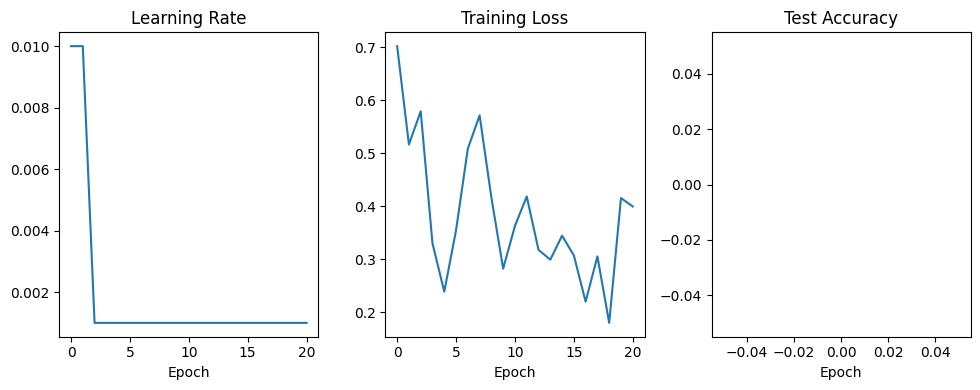

In [24]:
import matplotlib.pyplot as plt
#21에포크일 경우
log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# Lists to store data for plotting
learning_rates = []
training_losses = []
test_accuracies = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test_acc = test(model, epoch)  # Store the returned accuracy in test_acc
        scheduler.step()

        # Record learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Record training loss
        training_losses.append(losses[-1])

        # Record test accuracy
        test_accuracies.append(test_acc)  # Use test_acc

# Plot learning rate
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# Plot training loss
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()


  0%|          | 0.005333333333333333/30 [00:00<13:53, 27.78s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.257361


  0%|          | 0.05866666666666665/30 [00:01<13:53, 27.84s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.138385


  0%|          | 0.11199999999999995/30 [00:03<13:33, 27.23s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.234424


  1%|          | 0.16533333333333344/30 [00:04<12:58, 26.09s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.268137


  1%|          | 0.218666666666667/30 [00:05<12:49, 25.83s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.260377


  1%|          | 0.27200000000000035/30 [00:07<12:54, 26.05s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.175943


  1%|          | 0.32533333333333336/30 [00:08<12:59, 26.26s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.326904


  1%|▏         | 0.3786666666666664/30 [00:10<12:56, 26.23s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.254495


  1%|▏         | 0.4319999999999994/30 [00:11<12:56, 26.25s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.248991


  2%|▏         | 0.4853333333333324/30 [00:12<12:49, 26.07s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.254626


  2%|▏         | 0.5386666666666662/30 [00:14<13:18, 27.10s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.253088


  2%|▏         | 0.5920000000000003/30 [00:15<13:26, 27.43s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.187897


  2%|▏         | 0.6453333333333344/30 [00:17<13:16, 27.14s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.275548


  2%|▏         | 0.6986666666666685/30 [00:18<13:45, 28.16s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.254212


  3%|▎         | 0.7520000000000027/30 [00:20<12:57, 26.59s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.300846


  3%|▎         | 0.8053333333333368/30 [00:21<12:49, 26.34s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.321560


  3%|▎         | 0.8586666666666709/30 [00:22<12:54, 26.58s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.327804


  3%|▎         | 1.0026666666666728/30 [00:26<12:21, 25.58s/it]


Test Epoch: 1	Accuracy: 9409/11005 (85%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.219904


  4%|▎         | 1.061333333333338/30 [00:28<12:49, 26.58s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.279382


  4%|▎         | 1.1146666666666698/30 [00:29<12:52, 26.74s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.278705


  4%|▍         | 1.1680000000000017/30 [00:31<12:57, 26.97s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.267182


  4%|▍         | 1.2213333333333336/30 [00:32<13:09, 27.44s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.213614


  4%|▍         | 1.2746666666666655/30 [00:33<13:09, 27.50s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.267422


  4%|▍         | 1.3279999999999974/30 [00:35<13:01, 27.26s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.200066


  5%|▍         | 1.3813333333333293/30 [00:36<12:45, 26.73s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.247040


  5%|▍         | 1.4346666666666612/30 [00:38<12:31, 26.32s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.267310


  5%|▍         | 1.487999999999993/30 [00:39<12:35, 26.51s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.327061


  5%|▌         | 1.541333333333325/30 [00:41<12:52, 27.14s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.268386


  5%|▌         | 1.594666666666657/30 [00:42<12:24, 26.19s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.342759


  5%|▌         | 1.6479999999999888/30 [00:43<12:22, 26.20s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.220202


  6%|▌         | 1.7013333333333207/30 [00:45<12:25, 26.35s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.207992


  6%|▌         | 1.7546666666666526/30 [00:46<12:50, 27.28s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.293211


  6%|▌         | 1.8079999999999845/30 [00:48<12:57, 27.58s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.226850


  6%|▌         | 1.8613333333333164/30 [00:49<13:17, 28.36s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.318818


  7%|▋         | 2.0053333333333128/30 [00:53<11:41, 25.06s/it]


Test Epoch: 2	Accuracy: 9338/11005 (85%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.224185


  7%|▋         | 2.0639999999999827/30 [00:54<11:57, 25.68s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.219444


  7%|▋         | 2.1119999999999854/30 [00:56<12:08, 26.10s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.231970


  7%|▋         | 2.165333333333322/30 [00:57<12:10, 26.24s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.235365


  7%|▋         | 2.218666666666658/30 [00:59<12:12, 26.37s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.235547


  8%|▊         | 2.2719999999999945/30 [01:00<12:09, 26.30s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.233095


  8%|▊         | 2.325333333333331/30 [01:01<12:07, 26.29s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.321880


  8%|▊         | 2.378666666666667/30 [01:03<12:20, 26.80s/it] 

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.207658


  8%|▊         | 2.4320000000000035/30 [01:04<12:18, 26.78s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.159767


  8%|▊         | 2.48533333333334/30 [01:06<12:26, 27.14s/it] 

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.318444


  8%|▊         | 2.538666666666676/30 [01:07<12:40, 27.68s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.184858


  9%|▊         | 2.5920000000000125/30 [01:09<12:33, 27.48s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.183283


  9%|▉         | 2.645333333333349/30 [01:10<11:52, 26.04s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.294678


  9%|▉         | 2.698666666666685/30 [01:11<11:57, 26.27s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.182660


  9%|▉         | 2.7520000000000215/30 [01:13<11:59, 26.40s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.219127


  9%|▉         | 2.805333333333358/30 [01:14<12:09, 26.83s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.245956


 10%|▉         | 2.8586666666666942/30 [01:16<11:45, 25.98s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.283345


 10%|█         | 3.0026666666667023/30 [01:19<11:19, 25.17s/it]


Test Epoch: 3	Accuracy: 9431/11005 (86%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.272066


 10%|█         | 3.0613333333333723/30 [01:21<11:54, 26.52s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.161388


 10%|█         | 3.1146666666667087/30 [01:22<11:58, 26.72s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.238410


 11%|█         | 3.168000000000045/30 [01:24<12:06, 27.08s/it] 

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.216045


 11%|█         | 3.2213333333333813/30 [01:25<11:41, 26.19s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.278840


 11%|█         | 3.2746666666667177/30 [01:26<11:30, 25.84s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.158138


 11%|█         | 3.328000000000054/30 [01:28<11:36, 26.12s/it] 

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.158763


 11%|█▏        | 3.3813333333333904/30 [01:29<11:36, 26.17s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.181806


 11%|█▏        | 3.4346666666667267/30 [01:31<11:29, 25.97s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.275220


 12%|█▏        | 3.488000000000063/30 [01:32<11:23, 25.76s/it] 

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.267914


 12%|█▏        | 3.5413333333333994/30 [01:33<11:22, 25.79s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.261365


 12%|█▏        | 3.5946666666667357/30 [01:35<11:31, 26.18s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.223847


 12%|█▏        | 3.648000000000072/30 [01:36<11:48, 26.88s/it] 

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.159806


 12%|█▏        | 3.7013333333334084/30 [01:38<11:41, 26.68s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.303776


 13%|█▎        | 3.7546666666667448/30 [01:39<11:41, 26.72s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.181195


 13%|█▎        | 3.808000000000081/30 [01:41<11:35, 26.57s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.215044


 13%|█▎        | 3.8613333333334174/30 [01:42<11:21, 26.07s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.258882


 13%|█▎        | 4.005333333333424/30 [01:46<11:10, 25.79s/it] 


Test Epoch: 4	Accuracy: 9429/11005 (86%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.278678


 14%|█▎        | 4.064000000000084/30 [01:47<11:08, 25.77s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.377122


 14%|█▎        | 4.117333333333412/30 [01:49<11:29, 26.64s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.246094


 14%|█▍        | 4.170666666666739/30 [01:50<11:05, 25.77s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.162344


 14%|█▍        | 4.218666666666734/30 [01:51<11:27, 26.68s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.218838


 14%|█▍        | 4.2720000000000615/30 [01:53<11:34, 26.98s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.281682


 14%|█▍        | 4.325333333333389/30 [01:54<11:23, 26.64s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.274577


 15%|█▍        | 4.3786666666667164/30 [01:56<11:41, 27.38s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.247818


 15%|█▍        | 4.432000000000044/30 [01:57<11:03, 25.95s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.322952


 15%|█▍        | 4.485333333333371/30 [01:58<11:40, 27.44s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.272532


 15%|█▌        | 4.544000000000032/30 [02:00<10:52, 25.65s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.213740


 15%|█▌        | 4.592000000000026/30 [02:01<11:07, 26.29s/it] 

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.237600


 15%|█▌        | 4.645333333333354/30 [02:03<11:07, 26.31s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.274015


 16%|█▌        | 4.698666666666681/30 [02:04<11:03, 26.22s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.229154


 16%|█▌        | 4.752000000000009/30 [02:05<11:02, 26.25s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.259004


 16%|█▌        | 4.805333333333336/30 [02:07<11:08, 26.52s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.314209


 16%|█▌        | 4.858666666666664/30 [02:08<11:08, 26.59s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.245599


 17%|█▋        | 4.999999999999981/30 [02:12<11:01, 26.46s/it]



Test Epoch: 5	Accuracy: 9451/11005 (86%)

성능 향상이 없는 5 에폭 후 조기 종료.


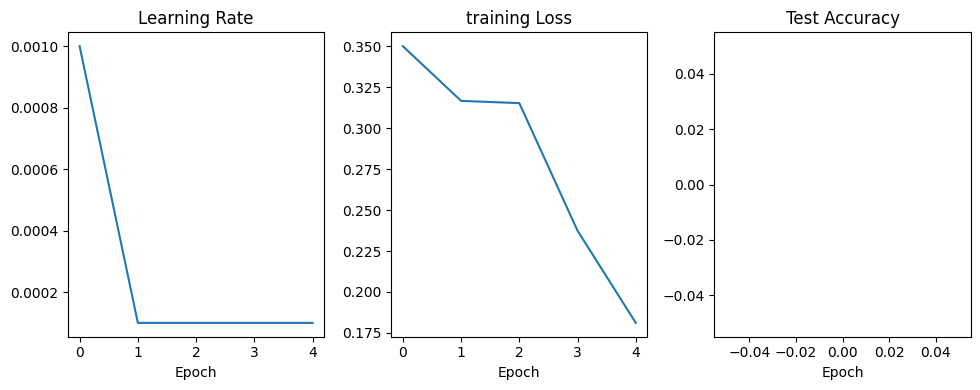

In [25]:
import matplotlib.pyplot as plt

# Early stopping 설정
early_stopping_patience = 5 # 성능 향상이 없는 에폭 수 10[Test Epoch: 10	Accuracy: 8481/11005 (77%)] ->5
best_accuracy = 0
no_improvement_count = 0

log_interval = 20
n_epoch = 30

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# 그래프를 그리기 위한 리스트
learning_rates = []
training_losses = []
test_accuracies = []

# 변환(transform)은 모델과 데이터가 동일한 장치(device)에서 실행되어야 합니다.
transform = transform.to(device)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test_acc = test(model, epoch)  # 정확도를 test_acc에 저장
        scheduler.step()

        # 학습률 기록
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # 훈련 손실 기록
        training_losses.append(losses[-1])

        # 테스트 정확도 기록
        if test_acc is not None:
            test_accuracies.append(test_acc)

        # 조기 종료 로직
        if test_acc is not None and test_acc > best_accuracy:
            best_accuracy = test_acc
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= early_stopping_patience:
            print(f"성능 향상이 없는 {epoch} 에폭 후 조기 종료.")
            break  # 성능 향상이 없으면 훈련 중지

# 학습률 그래프 그리기
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# 훈련 손실 그래프 그리기
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("training Loss")
plt.xlabel("Epoch")

# 테스트 정확도 그래프 그리기
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()


The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [26]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [27]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: nine.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [40]:
import sys
sys.path


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython']

In [29]:
#ModuleNotFoundError: No module named 'pydub'문제 해결
#"pydub" 패키지의 경로가 경로 리스트에 없어서, 필요한 경로를 직접 추가
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [30]:
def record(seconds=3):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 3 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: three.


In [32]:
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

## Conclusion

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


